# Première modélisation via les techniques de regression

In [4]:
import pandas as pd 
import numpy as np
#from sklearn import model_selection, preprocessing
#from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator,TransformerMixin

Chargement base DVF, base concernant les salaires, et concernant la population

In [25]:
df = pd.read_csv("06 - dvf_with_equip_loyers_revenus_2020v2.csv")

#On garde la france metropolitaine
df = df[(df["Code departement"] != 971)&
        (df["Code departement"] != 972)&
        (df["Code departement"] != 973)&
        (df["Code departement"] != 974)]

#on intègre les salaires
salaire = pd.read_csv("salaire.csv",sep=";",decimal=",",dtype = {'Code departement': int})
salaire = salaire[['SNHMO18','SNHMFO18',"Code departement"]]
df = df.merge(salaire, on = "Code departement", how = 'left')
del salaire

#on intègre la population par commune
population = pd.read_csv("population.csv", sep =";", dtype = {'Population municipale': int,
                                                              'Population comptee a part':int,
                                                              'Population totale':int,
                                                              'Code commune INSEE':int})
population = population[["Population totale",'Code commune INSEE']]
df = df.merge(population, on = "Code commune INSEE", how = 'left')
del population

Gestion des valeurs manquantes : à voir si autre alternative pour DISP_MED??

In [6]:
df[['DISP_Q118','DISP_MED18','DISP_Q318','DISP_GI18']] = df[['DISP_Q118','DISP_MED18','DISP_Q318','DISP_GI18']].fillna(df[['DISP_Q118','DISP_MED18','DISP_Q318','DISP_GI18']].median())
df = df.fillna(0)

Création des nouvelles features 

In [7]:
#Prix moyen par département
prix_moyen_dept = pd.DataFrame(df.groupby(["dep_name"]).mean()["Valeur fonciere"]).rename({"Valeur fonciere":'Prix moyen par departement'},axis =1)
df = df.merge(prix_moyen_dept, on = "dep_name", how = "left")
del prix_moyen_dept

#Prix moyen m2 par département
prix_m2_moyen_dept = pd.DataFrame(df.groupby(["dep_name"]).mean()["Prix m2"]).rename({"Prix m2":'Prix m2 moyen par departement'},axis =1)
df = df.merge(prix_m2_moyen_dept, on = "dep_name", how = "left")
del prix_m2_moyen_dept

#prix moyen par région
prix_moyen_reg = pd.DataFrame(df.groupby(["region_name"]).mean()["Valeur fonciere"]).rename({"Valeur fonciere":'Prix moyen par region'},axis =1)
df = df.merge(prix_moyen_reg, on = "region_name", how = "left")
del prix_moyen_reg

#prix moyen m2 par région
prix_m2_moyen_reg = pd.DataFrame(df.groupby(["region_name"]).mean()["Prix m2"]).rename({"Prix m2":'Prix m2 moyen par region'},axis =1)
df = df.merge(prix_m2_moyen_reg, on = "region_name", how = "left")
del prix_m2_moyen_reg

#prix moyen par commune
prix_moyen_commune = pd.DataFrame(df.groupby(["Commune"]).mean()["Valeur fonciere"]).rename({"Valeur fonciere":'Prix moyen par commune'},axis =1)
df = df.merge(prix_moyen_commune, on = "Commune", how = "left")
del prix_moyen_commune

#prix moyen par commune
prix_m2_moyen_commune = pd.DataFrame(df.groupby(["Commune"]).mean()["Prix m2"]).rename({"Prix m2":'Prix m2 moyen par commune'},axis =1)
df = df.merge(prix_m2_moyen_commune, on = "Commune", how = "left")
del prix_m2_moyen_commune

df["Nb equip total"] = df["Alimentation"] + df["Aéroport"] +df["Baignade"] +df["Banques"] +df["Boulangerie"] +df["Camping"] 
df["Nb equip total"] = df["Nb equip total"] + df["Cinéma"] +df["Collège ou lycée"] +df["Crèche"] +df["Ecole mat et primaire"] 
df["Nb equip total"] = df["Nb equip total"]+df["Ecole sup"] +df["Etab hospi"] +df["Gare"] +df["Gare nationale"] +df["Hotels"] 
df["Nb equip total"] = df["Nb equip total"]+df["Info touristique"] +df["Parcours sportif/santé"]  +df["Pharmacie"]   
df["Nb equip total"] = df["Nb equip total"]+df["Police ou gendarmerie"]+df["Port plaisance"]+df["Restaurants"]+df["Resto U"] 
df["Nb equip total"] = df["Nb equip total"]+df["Résidence U"] +  df["Salle multisport"]

df.drop(['Unnamed: 0', 'Date mutation','Type de voie','Nombre de lots',
         'Code commune INSEE', 'Adresse','lon', 'lat', 'Code postal 5 chiffres',
         'code_iris_clean','Code departement','dep_name','region_name','Commune',
         'année','mois','keepdep','Prix m2'], axis = 1, inplace = True)


# Essai de supprimer dans un transformateur les équipements

In [110]:
class Add_Equipements(BaseEstimator,TransformerMixin):
    def __init__(self,Equipement = True):
        self.Equipement = Equipement 
    def fit(self,df, y = None):
        return self
    def transform(self, df, y = None):
        if self.Equipement:
            return df
        else:
            df = df.drop([['Alimentation','Aéroport', 'Baignade', 
                          'Banques','Boulangerie', 'Camping', 'Cinéma', 
                          'Collège ou lycée', 'Crèche''Ecole mat et primaire',
                          'Ecole sup', 'Etab hospi', 'Gare','Gare nationale', 'Hotels',
                          'Info touristique','Parcours sportif/santé', 'Pharmacie',
                          'Police ou gendarmerie', 'Port plaisance', 'Restaurants', 
                          'Resto U', 'Résidence U','Salle multisport']], axis = 1)
            return df
     

In [111]:
attr_addrer = CombinedAttributeAdder(False)
test = attr_addrer.transform(df)

In [112]:
test.columns


Index(['Unnamed: 0', 'Date mutation', 'Valeur fonciere', 'Type de voie',
       'Commune', 'Code departement', 'Nombre de lots', 'Type local',
       'Surface reelle bati', 'Nombre pieces principales', 'Surface terrain',
       'Code commune INSEE', 'Adresse', 'Prix m2', 'Paris', 'dep_name',
       'region_name', 'Mer', 'lon', 'lat', 'Code postal 5 chiffres',
       'code_iris_clean', 'Aéroport', 'Baignade', 'Banques', 'Boulangerie',
       'Camping', 'Cinéma', 'Collège ou lycée', 'Crèche',
       'Ecole mat et primaire', 'Ecole sup', 'Etab hospi', 'Gare',
       'Gare nationale', 'Hotels', 'Info touristique',
       'Parcours sportif/santé', 'Pharmacie', 'Police ou gendarmerie',
       'Port plaisance', 'Restaurants', 'Resto U', 'Résidence U',
       'Salle multisport', 'loy_appart', 'loy_maison', 'keepdep', 'DISP_Q118',
       'DISP_MED18', 'DISP_Q318', 'DISP_GI18', 'année', 'mois', 'SNHMO18',
       'SNHMFO18', 'Population totale'],
      dtype='object')

In [ ]:
df = df.drop(["Alimentation",'Aéroport', 'Baignade', 'Banques',
       'Boulangerie', 'Camping', 'Cinéma', 'Collège ou lycée', 'Crèche',
       'Ecole mat et primaire', 'Ecole sup', 'Etab hospi', 'Gare',
       'Gare nationale', 'Hotels', 'Info touristique',
       'Parcours sportif/santé', 'Pharmacie', 'Police ou gendarmerie',
       'Port plaisance', 'Restaurants', 'Resto U', 'Résidence U',
       'Salle multisport'], axis = 1)

# Remplacement plus intelligente des DISP_Q118

In [44]:
class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        self.age_means_ = {}

    def fit(self, df, y=None):
        self.age_means_ = df.groupby(['Code departement']).DISP_Q118.mean()
        return self

    def transform(self, df, y=None):
        for key, value in self.age_means_.items():
            df.loc[((np.isnan(df["DISP_Q118"]))) & ((df['Code departement'] == key[0])), 'DISP_Q118'] = value
        return df

In [52]:
test = CustomImputer()

In [53]:
test2 = test.transform(df)

In [32]:
test2.head()

Unnamed: 0 Date mutation  Valeur fonciere Type de voie Commune  \
0           0    2020-02-01         268800.0          RUE   PARIS   
1           1    2020-06-01         878378.0           BD   PARIS   
2           2    2020-10-01         680000.0          RUE   PARIS   
3           3    2020-08-01         370000.0          RUE   PARIS   
4           4    2020-09-01         741500.0          RUE   PARIS   

   Code departement  Nombre de lots   Type local  Surface reelle bati  \
0                75               2  Appartement                 24.0   
1                75               3  Appartement                 66.0   
2                75               1  Appartement                 51.0   
3                75               1  Appartement                 21.0   
4                75               2  Appartement                 61.0   

   Nombre pieces principales  ...  keepdep  DISP_Q118 DISP_MED18  DISP_Q318  \
0                        1.0  ...     True    25840.0    43390.0    70300.0   
1                        2.0  ...     True    22130.0    36780.0    66010.0   
2                        2.0  ...     True    16970.0    29180.0    43190.0   
3                        1.0  ...     True    21500.0    35390.0    57030.0   
4                        2.0  ...     True        NaN        NaN        NaN   

   DISP_GI18 année mois    SNHMO18  SNHMFO18  Population totale  
0      0.461  2020    2  11.110637  10.55109              36827  
1      0.464  2020    6  11.110637  10.55109              16236  
2      0.398  2020   10  11.110637  10.55109              34305  
3      0.482  2020    8  11.110637  10.55109              34305  
4        NaN  2020    9  11.110637  10.55109              16236  

[5 rows x 58 columns]

Visualisation

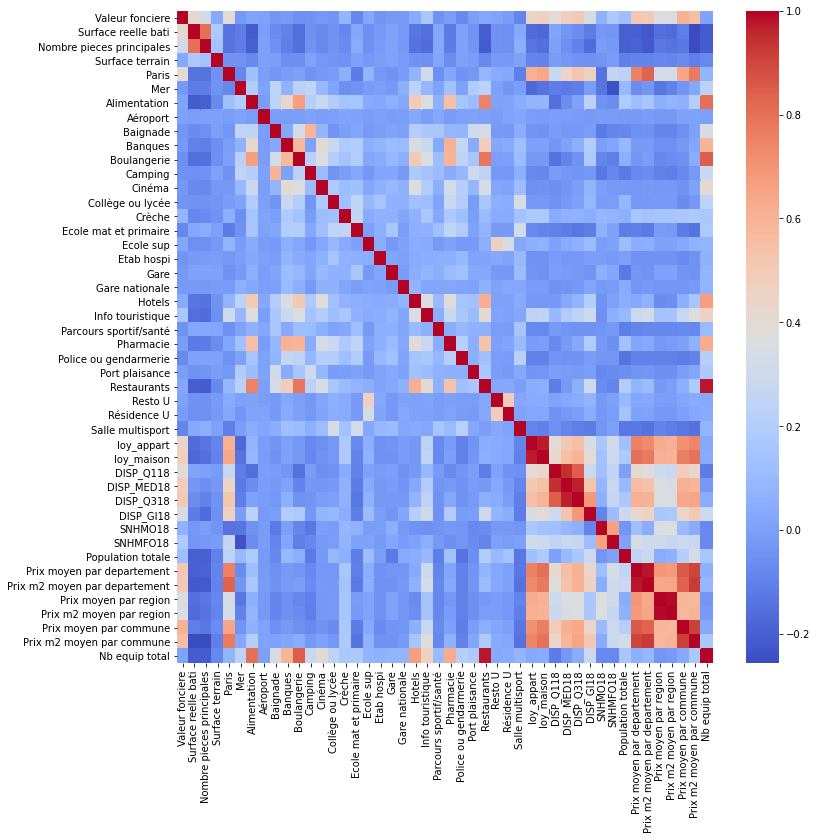

In [5]:
cor = df.corr()
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(cor, ax= ax, cmap="coolwarm");

On repère quelques corrélations entre certaines variables (celles vers la fin, prix moyen et prix moyen par m2)

Varaibles les plus corrélées avec notre target.

In [6]:
cor['Valeur fonciere'].sort_values(ascending = False)

Valeur fonciere                  1.000000
Prix moyen par commune           0.605162
Prix m2 moyen par commune        0.554191
Prix moyen par departement       0.518106
Prix m2 moyen par departement    0.506079
DISP_Q318                        0.504598
DISP_MED18                       0.479536
loy_maison                       0.471510
loy_appart                       0.441919
Surface reelle bati              0.411593
DISP_Q118                        0.400660
Paris                            0.393207
Prix moyen par region            0.358417
Prix m2 moyen par region         0.354924
DISP_GI18                        0.343453
Nombre pieces principales        0.313305
SNHMFO18                         0.175825
Info touristique                 0.162705
Population totale                0.118173
Crèche                           0.084383
SNHMO18                          0.063366
Hotels                           0.041812
Surface terrain                  0.037443
Ecole sup                        0

Les équipements ne ressortent pas réellement, une piste serait des les utiliser différement

In [7]:
#del cor
objet = df[["Type local"]]
df.drop(["Type local"], axis = 1, inplace = True)
df = df.join(pd.get_dummies(objet))
del objet
# split de notre target et variables explicatives 
target = df["Valeur fonciere"]
data = df.drop("Valeur fonciere",axis = 1)

Standardisation

In [8]:
data_scaled = pd.DataFrame(MinMaxScaler().fit_transform(data), columns = data.columns)

Split en train/test : il faudrait peut etre faire ca plus proprement (split égale à 10% dans chaque départment ?)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data_scaled, target, test_size=0.2, random_state=789)

### Regression linéaire standard

In [10]:
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print("Coefficient de détermination du modèle :", lr.score(X_train, y_train))
print('Score de l ensemble de test', lr.score(X_test,y_test))
print("RMSE test : ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE test : ", np.sqrt(mean_absolute_error(y_test, y_pred)))
res = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
res

Coefficient de détermination du modèle : 0.6706996316655736
Score de l ensemble de test 0.671918343268135
RMSE test :  98160.9951285579
MAE test :  249.8274680654854


Actual      Predicted
250976  126000.0  153729.943957
468943   67416.0   78781.119002
354563  142000.0  172557.822139
49003   121900.0  132272.208563
309520   51300.0   -5971.679916
...          ...            ...
304381  133300.0  180633.313186
408570  280000.0  309772.579030
159071   55000.0   82391.767458
59772   132620.0  202590.058151
242348  120000.0   76006.263275

[100179 rows x 2 columns]

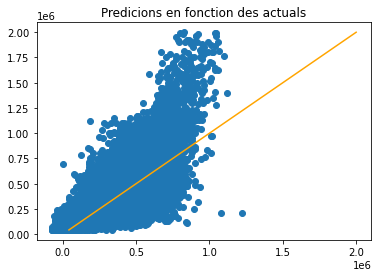

In [11]:
plt.scatter(y_pred, y_test)
plt.plot((y_test.min(),y_test.max()), (y_test.min(),y_test.max()), 'orange')
plt.title("Predicions en fonction des actuals");

Gros doute sur la linéarité de la relation

Analyse des résidus : à controler l'homoscédasticité et la normalité

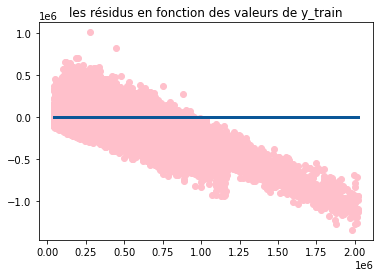

In [12]:
pred_train = lr.predict(X_train)
residus = pred_train - y_train
plt.scatter(y_train, residus, color = 'pink')
plt.plot((y_train.min(),y_train.max()), (0,0), lw=3, color = '#0a5798')
plt.title("les résidus en fonction des valeurs de y_train");

Clairement on a pas de répartition uniforme autour de la droite d'axe y= 0.

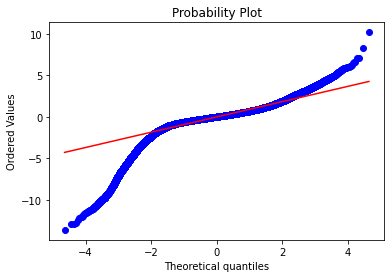

In [13]:
residus_norm = (residus-residus.mean())/residus.std()
stats.probplot(residus_norm, plot = plt)
plt.show()

Clairement les résidus n'ont pas un comportement gaussien !!!

In [14]:
cor['Valeur fonciere'].sort_values(ascending = False)[:20]

Valeur fonciere                  1.000000
Prix moyen par commune           0.605162
Prix m2 moyen par commune        0.554191
Prix moyen par departement       0.518106
Prix m2 moyen par departement    0.506079
DISP_Q318                        0.504598
DISP_MED18                       0.479536
loy_maison                       0.471510
loy_appart                       0.441919
Surface reelle bati              0.411593
DISP_Q118                        0.400660
Paris                            0.393207
Prix moyen par region            0.358417
Prix m2 moyen par region         0.354924
DISP_GI18                        0.343453
Nombre pieces principales        0.313305
SNHMFO18                         0.175825
Info touristique                 0.162705
Population totale                0.118173
Crèche                           0.084383
Name: Valeur fonciere, dtype: float64

In [16]:
signif_feat= df[["Valeur fonciere","Prix moyen par commune","Prix m2 moyen par commune",
              "Prix moyen par departement","Prix m2 moyen par departement","DISP_Q318","DISP_MED18",
              "loy_maison","loy_appart","Surface reelle bati","DISP_Q118",
              "Paris","Prix moyen par region","Prix m2 moyen par region","DISP_GI18",
              "Nombre pieces principales","SNHMFO18","Info touristique","Population totale"]]

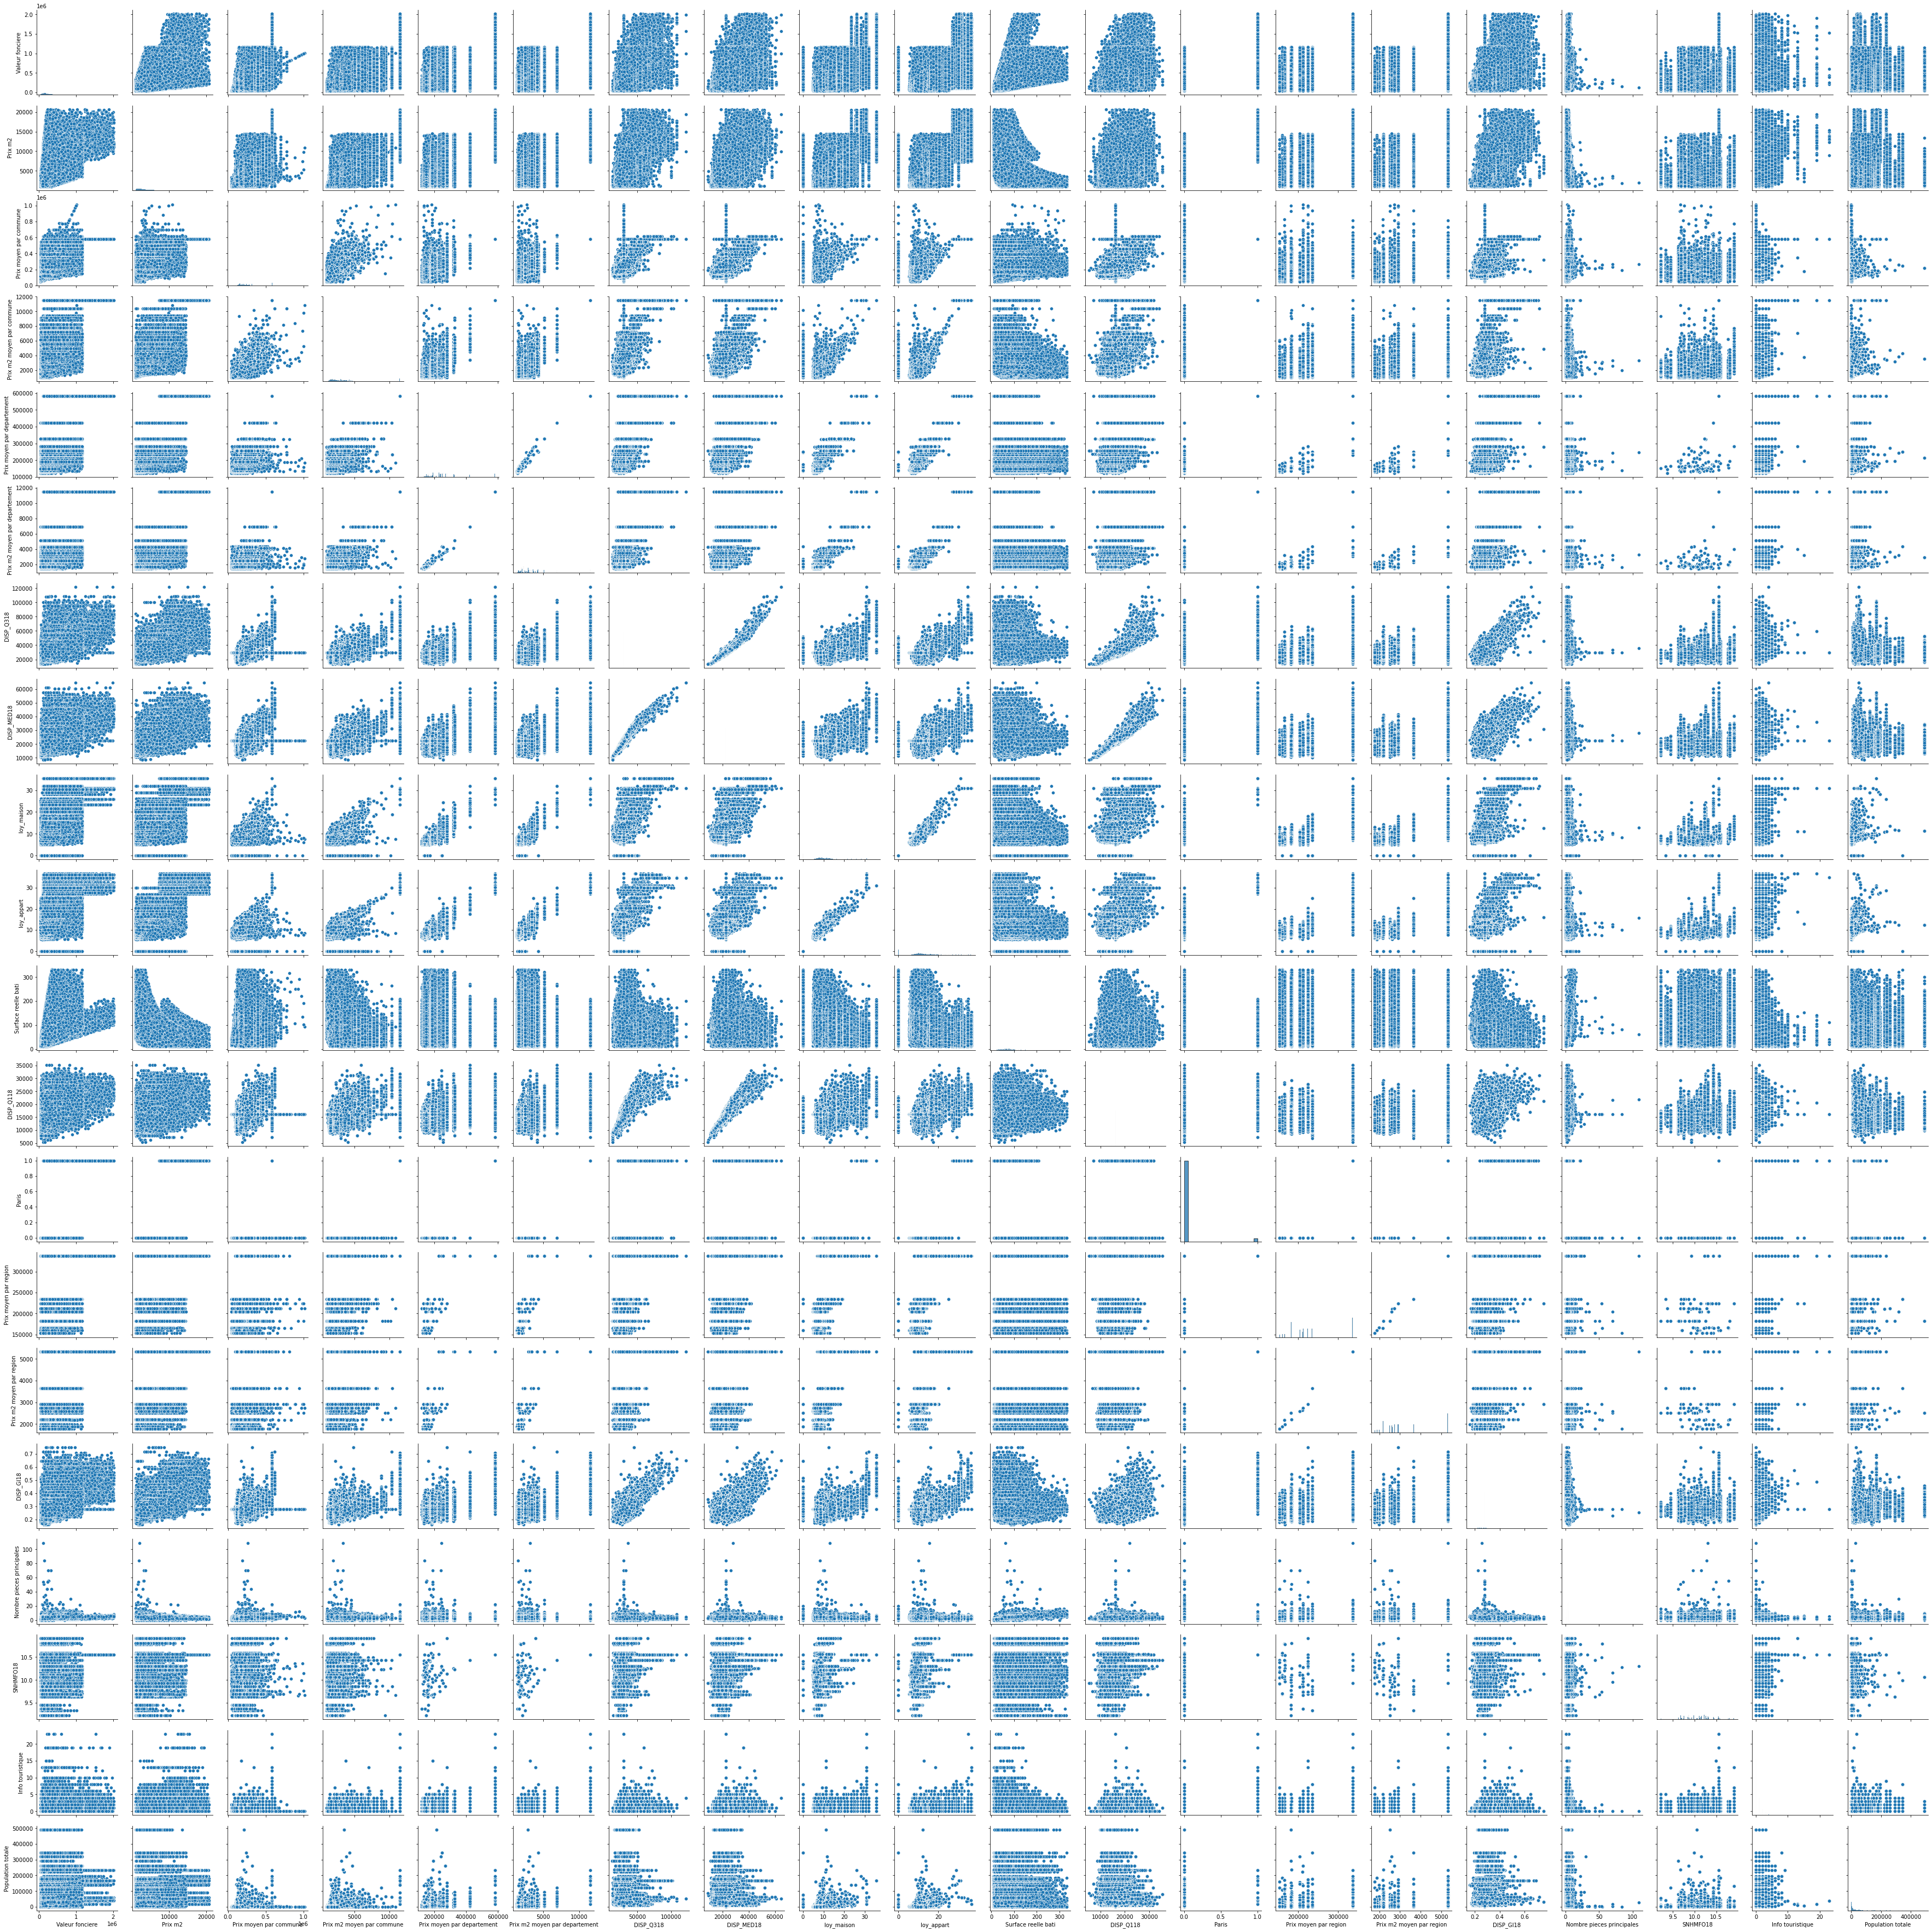

In [68]:
sns.pairplot(signif_feat)

Clairement on a plusieurs problèmes :
- valeurs bianiraies (0 et 1 : Paris Oui ou Non)
- relations linéaires entre valeurs explicatives (exemple : DISP_Q318 et DISP_MED18 )
- des relations non linéaires avec la variables cible

Essaie de selection de modèles

In [18]:
from sklearn.feature_selection import SelectKBest, f_regression
sk = SelectKBest(f_regression, k=11)
sk.fit(data, target)
print(data.columns[sk.get_support()])
sk_train = sk.transform(X_train)
sk_test = sk.transform(X_test)
sklr = LinearRegression()
sklr.fit(sk_train, y_train)
y_pred_sklr = sklr.predict(sk_test)
print(sklr.score(sk_train, y_train))
print(sklr.score(sk_test, y_test))
print("RMSE test : ", np.sqrt(mean_squared_error(y_test, y_pred_sklr)))
print("MAE test : ", np.sqrt(mean_absolute_error(y_test, y_pred_sklr)))

Index(['Surface reelle bati', 'Paris', 'loy_appart', 'loy_maison', 'DISP_Q118',
       'DISP_MED18', 'DISP_Q318', 'Prix moyen par departement',
       'Prix m2 moyen par departement', 'Prix moyen par commune',
       'Prix m2 moyen par commune'],
      dtype='object')
0.6616746168961158
0.663288642164986
RMSE test :  99443.60523725787
MAE test :  251.40638156680487


In [20]:
res_sklr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_sklr})
res_sklr

Actual      Predicted
250976  126000.0  163260.824968
468943   67416.0   90081.048929
354563  142000.0  166758.639199
49003   121900.0  130395.334318
309520   51300.0   11029.332600
...          ...            ...
304381  133300.0  148826.500316
408570  280000.0  293222.752530
159071   55000.0   66956.518304
59772   132620.0  208535.043266
242348  120000.0   72557.503878

[100179 rows x 2 columns]

### Random Forest

In [21]:
regr = RandomForestRegressor(random_state=0)
regr.fit(X_train,y_train)
print("score train:",regr.score(X_train, y_train))
print("score test:", regr.score(X_test, y_test))
pred_rf = regr.predict(X_test)
print("RMSE test : ", np.sqrt(mean_squared_error(pred_rf,y_test)))
print("MAE test : ", np.sqrt(mean_absolute_error(y_test, pred_rf)))
res_rf = pd.DataFrame({'Actual': y_test, 'Predicted': pred_rf})
res_rf

score train: 0.974261686145994
score test: 0.8476013034366243
RMSE test :  66901.92345978947
MAE test :  203.40143109120356


Actual      Predicted
250976  126000.0  176610.422222
468943   67416.0   94763.343848
354563  142000.0  149236.655000
49003   121900.0  136421.600000
309520   51300.0   55569.946364
...          ...            ...
304381  133300.0  130676.750000
408570  280000.0  341454.580000
159071   55000.0   52426.497593
59772   132620.0  199478.708333
242348  120000.0  100161.270000

[100179 rows x 2 columns]

### Support Vector Regressor

In [ ]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X_train, y_train)

In [ ]:
print("score train:",regressor.score(X_train, y_train))
print("score test:", regressor.score(X_test, y_test))
pred_svr = regressor.predict(X_test)
print(" E test : ", np.sqrt(mean_squared_error(pred_svr,y_test)))
print("MAE test : ", np.sqrt(mean_absolute_error(y_test, pred_svr)))
res_svr = pd.DataFrame({'Actual': y_test, 'Predicted': pred_svr})
res_svr

Points de questionnement :

- Comment gérer la regression dans ce cas ?

- Comment gérer les variables quantitatives avec beaucoup de modalités (impossible de binariser dans ca cas) exemple = Commune, départment ...
- Quelles mesures pour bien analyser les performances des modèles
- Peut-être se tourner vers d'autres algorithmes qui ne nécessité pas de linéarité et d'indépendances des variables explicatives

- Appliquer une transformation à la variale cible (style box-plot, log ...)

- séparer par régions, ville (paris...), grandes villes ..., type de local

- analyser les résultats